# Registration Evaluation

In [1]:
import os
import cv2
import csv
import kornia as K
import kornia.feature as KF
import kornia.geometry.transform as KT
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import skimage as ski
import pandas as pd
from scipy.stats import t
import math
from tqdm import tqdm

from utils import *
from loftr import plot_image_pair, plot_overlay, scale_image, loftr_match, tps_skimage, erode_crop_leaf
from DatasetTools.LeafImageSeries import LeafDataset

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="monai"
)


<frozen importlib._bootstrap_external>:1329: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
/layers/paketo-buildpacks_poetry-install/poetry-venv/datascience-python-renku-dependencies-xS3fZVNL-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = '../leaf-image-sequences'
uid_dir = base_dir + '/processed/reg'
leaf_uids = [
    name for name in os.listdir(uid_dir)
    if os.path.isdir(os.path.join(uid_dir, name))
]

In [3]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0090057_18", 
    # leaf_uid="ESWW0070020_1",
    leaf_uid="ESWW0070023_6", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'cropped_images', 'rois', 'images', 'keypoints'),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...


Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading cropped images...
Loading ROIs...
Loading Target Masks...
Loading Leaf Masks...
Loading Segmentation Masks...
Loading target images...
Loading keypoints...


## Fetching Pairs of Registered Images

In [3]:
def fetch_image_pair(leaf, fixed_img_ind, moving_img_ind, method):
    if method == "Pairwise Affine":
        fixed_img = convert_image_to_tensor(leaf.target_images[fixed_img_ind])
        moving_img = convert_image_to_tensor(leaf.target_images[moving_img_ind])
        return fixed_img, moving_img
    elif method == "LoFTR + TPS":
        raise NotImplementedError
    
    else:
        raise ValueError(f'Unknown registration method {method}')

In [3]:
def fetch_image_mask_pair(leaf, fixed_img_ind, moving_img_ind, method):
    if method == "Pairwise Affine":
        img_fixed = convert_image_to_tensor(leaf.target_images[fixed_img_ind])
        mask_fixed = convert_image_to_tensor(leaf.target_masks[fixed_img_ind])
        if (img_fixed is None) or (mask_fixed is None): 
            print(f"Error: missing data for leaf {leaf.leaf_uid}")
            return img_fixed, None, mask_fixed, None
        mask_fixed[mask_fixed != 0] = 1

        img_moving = convert_image_to_tensor(leaf.target_images[moving_img_ind])
        mask_moving = convert_image_to_tensor(leaf.target_masks[moving_img_ind])
        if (img_moving is None) or (mask_moving is None): 
            print(f"Error: missing data for leaf {leaf.leaf_uid}")
            return img_fixed, img_moving, mask_fixed, mask_moving
        mask_moving[mask_moving != 0] = 1
        return img_fixed, img_moving, mask_fixed, mask_moving
        
    else:
        
        if method in ("LoFTR + TPS ROI", "LoFTR + TPS ROI with Markers"):
            # if we want to keep the markers, don't rescale the image
            img_scale = {"scale": 1} if method == "LoFTR + TPS ROI with Markers" else {}


            # fixed image
            if fixed_img_ind == 0:
                img_fixed = convert_image_to_tensor(leaf.images[fixed_img_ind])
                mask_fixed = convert_image_to_tensor(leaf.leaf_masks[fixed_img_ind])

                H, W = img_fixed.shape[2], img_fixed.shape[3]
                roi = leaf.rois[fixed_img_ind]
                rot_mat = roi["rotation_matrix"]
                bbox = roi["bounding_box"]
                if rot_mat is None or bbox is None:
                    print(f"Error: missing data for leaf {leaf.leaf_uid}")
                    return None, None, None, None
                rot_mat = np.asarray(rot_mat)
                bbox = np.asarray(bbox)

                img_fixed = K.geometry.transform.warp_affine(img_fixed, torch.Tensor(rot_mat).unsqueeze(0), (H, W)) #, align_corners=True)
                img_fixed = crop_img(img_fixed, bbox[:,0].min(), bbox[:,0].max()-1, bbox[:,1].min(), bbox[:,1].max()-1)
                # img_fixed = img_fixed * mask_fixed
                img_fixed = erode_leaf(img_fixed, mask_fixed, **img_scale)

            else:
                img_fixed, mask_fixed = erode_crop_leaf(leaf, fixed_img_ind, return_mask=True, **img_scale)
            
            if (img_fixed is None) or (mask_fixed is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, None, mask_fixed, None

            # moving image
            img_moving, mask_moving = erode_crop_leaf(leaf, moving_img_ind, return_mask=True)
            if (img_moving is None) or (mask_moving is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, img_moving, mask_fixed, mask_moving
            size_factor = 2

        elif method in ("LoFTR + TPS Full", "LoFTR + TPS Full with Markers"):
            # if we want to keep the markers, don't rescale the image
            img_scale = {"scale": 1} if method == "LoFTR + TPS ROI with Markers" else {}

            # fixed image
            img_fixed = convert_image_to_tensor(leaf.cropped_images[fixed_img_ind])
            mask_fixed = convert_image_to_tensor(leaf.seg_masks[fixed_img_ind])
            if (img_fixed is None) or (mask_fixed is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, None, mask_fixed, None
            mask_fixed[mask_fixed!=0] = 1
            rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_fixed)
            img_fixed = crop_img(img_fixed, cmin, cmax, rmin, rmax)
            mask_fixed = crop_img(mask_fixed, cmin, cmax, rmin, rmax)
            img_fixed = erode_leaf(img_fixed, mask_fixed, **img_scale)

            # moving image
            img_moving = convert_image_to_tensor(leaf.cropped_images[moving_img_ind])
            mask_moving = convert_image_to_tensor(leaf.seg_masks[moving_img_ind])
            if (img_moving is None) or (mask_moving is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, img_moving, mask_fixed, mask_moving
            mask_moving[mask_moving!=0] = 1
            rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_moving)
            img_moving = crop_img(img_moving, cmin, cmax, rmin, rmax)
            mask_moving = crop_img(mask_moving, cmin, cmax, rmin, rmax)
            img_moving = erode_leaf(img_moving, mask_moving, **img_scale)

            size_factor = 4
         
        else:
            raise ValueError(f'Unknown registration method {method}')

        # resize
        height = max(img_fixed.shape[-2], img_moving.shape[-2])
        width = max(img_fixed.shape[-1], img_moving.shape[-1])

        padder = K.augmentation.PadTo((height, width))

        img_fixed = padder(img_fixed)
        img_moving = padder(img_moving)
        mask_fixed = padder(mask_fixed)
        mask_moving = padder(mask_moving)        

        
        H = int(height/size_factor)
        W = int(width/size_factor) 

        img_fixed = K.geometry.resize(img_fixed, (H, W), antialias=True)
        mask_fixed = K.geometry.resize(mask_fixed, (H, W), antialias=False, interpolation='nearest')
        img_moving = K.geometry.resize(img_moving, (H, W), antialias=True)
        mask_moving = K.geometry.resize(mask_moving, (H, W), antialias=False, interpolation='nearest')

        # fig, ax = plot_image_pair(img_fixed, img_moving, fixed_img_ind, moving_img_ind)
        # fig.show()
        # fig, ax = plot_image_pair(mask_fixed, mask_moving, fixed_img_ind, moving_img_ind)
        # fig.show()


        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(img_fixed, img_moving, verbose=False, return_n_matches=True)

        thrsld = 0.5
        
        if n_matches['conf_matches'] > 3:
            warped_moving_img, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, img_moving, verbose=False)
            warped_moving_mask, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, mask_moving, verbose=False)
        else:
            print("No enough matches for TPS found")
            warped_moving_img = None
            warped_moving_mask = None

        return img_fixed, warped_moving_img, mask_fixed, warped_moving_mask
    
    
    # else:
    #     raise ValueError(f'Unknown registration method {method}')

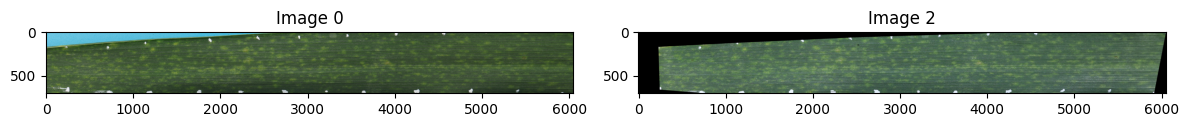

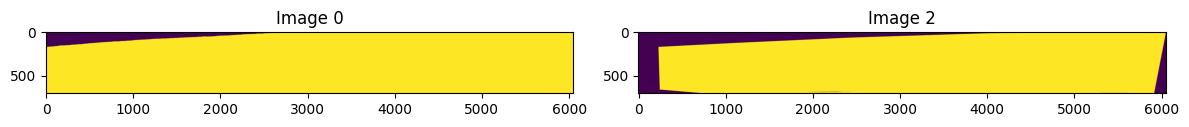

In [7]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, 3, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, 2)
fig.show()

### Piecewise Affine

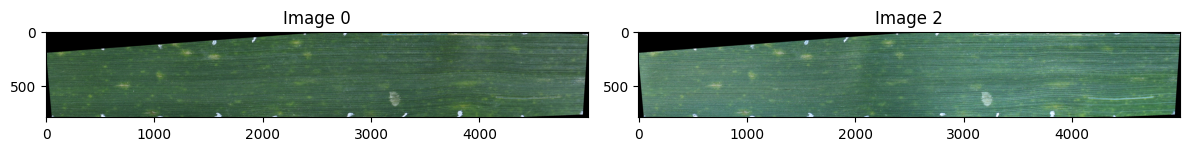

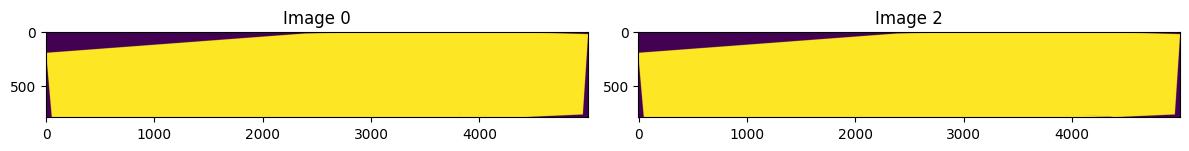

In [7]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 1, 2, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, moving, 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, moving_mask, 0, 2)
fig.show()

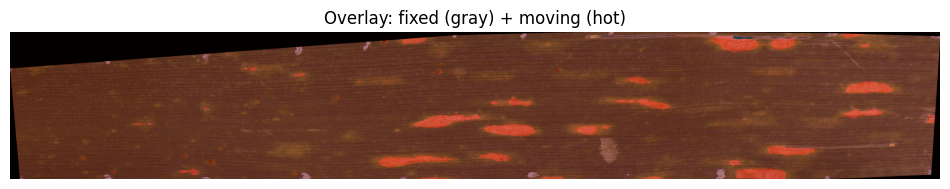

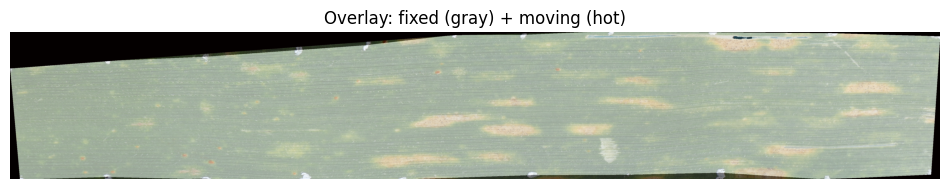

tensor([0., 1.])


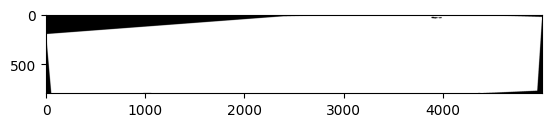

In [27]:
ind = 10
fig = plot_overlay(leaf.target_images[ind], leaf.target_masks[ind])
fig = plot_overlay(leaf.target_images[ind], leaf.leaf_masks[ind])
mask = convert_image_to_tensor(leaf.target_masks[ind])
mask[mask!=0] = 1
print(mask.unique())
# plt.imshow(leaf.target_masks[ind])
plt.imshow(convert_img_tensor_to_numpy(mask), cmap='gray', vmin=0, vmax=1)
# plot_image_pair(convert_image_to_tensor(leaf.target_images[ind]), convert_image_to_tensor(leaf.leaf_masks[ind]))

### LoFTR + TPS Full Leaf

In [69]:
def fetch(leaf, fixed_img_ind, moving_img_ind, size_factor=2, method="LoFTR + TPS"):
    if method == "LoFTR + TPS":

        # fixed image
        img_fixed = convert_image_to_tensor(leaf.cropped_images[fixed_img_ind])
        mask_fixed = convert_image_to_tensor(leaf.seg_masks[fixed_img_ind])
        mask_fixed[mask_fixed!=0] = 1
        rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_fixed)
        img_fixed = crop_img(img_fixed, cmin, cmax, rmin, rmax)
        mask_fixed = crop_img(mask_fixed, cmin, cmax, rmin, rmax)
        img_fixed = erode_leaf(img_fixed, mask_fixed)

        # moving image
        img_moving = convert_image_to_tensor(leaf.cropped_images[moving_img_ind])
        mask_moving = convert_image_to_tensor(leaf.seg_masks[moving_img_ind])
        mask_moving[mask_moving!=0] = 1
        rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_moving)
        img_moving = crop_img(img_moving, cmin, cmax, rmin, rmax)
        mask_moving = crop_img(mask_moving, cmin, cmax, rmin, rmax)
        img_moving = erode_leaf(img_moving, mask_moving)
         

        height = max(img_fixed.shape[-2], img_moving.shape[-2])
        width = max(img_fixed.shape[-1], img_moving.shape[-1])

        padder = K.augmentation.PadTo((height, width))

        img_fixed = padder(img_fixed)
        img_moving = padder(img_moving)
        mask_fixed = padder(mask_fixed)
        mask_moving = padder(mask_moving)

        H = int(height/size_factor)
        W = int(width/size_factor) 

        img_fixed = K.geometry.resize(img_fixed, (H, W), antialias=True)
        mask_fixed = K.geometry.resize(mask_fixed, (H, W), antialias=True)
        img_moving = K.geometry.resize(img_moving, (H, W), antialias=True)
        mask_moving = K.geometry.resize(mask_moving, (H, W), antialias=True)

        # fig, ax = plot_image_pair(img_fixed, img_moving)
        # fig.show()
        # fig, ax = plot_image_pair(mask_fixed, mask_moving)
        # fig.show()

        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(img_fixed, img_moving, verbose=False, return_n_matches=True)

        print(f"'total_matches': {n_matches['total_matches']}, 'conf_matches': {int(n_matches['conf_matches'])}, 'inliers': {n_matches['inliers']}")
        
        thrsld = 0.5
        
        if n_matches['conf_matches'] > 3:
            warped_moving_img, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, img_moving, verbose=True)
            print(type(warped_moving_img))
            warped_moving_mask, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, mask_moving, verbose=True)

        else:
            print("No enough matches for TPS found")
            warped_moving_img = torch.zeros_like(img_fixed)
            warped_moving_mask = torch.zeros_like(mask_fixed)

        fig, ax = plot_image_pair(img_moving, convert_image_to_tensor(warped_moving_img))
        fig.show()
        fig, ax = plot_image_pair(convert_image_to_tensor(warped_moving_mask), convert_image_to_tensor(warped_moving_img))
        fig.show()
        fig = plot_overlay(img_fixed, warped_moving_img)

        return img_fixed, warped_moving_img, mask_fixed, warped_moving_mask
    

In [ ]:
out = fetch(leaf, 3, 10, size_factor=2)

#### Mask & Crop

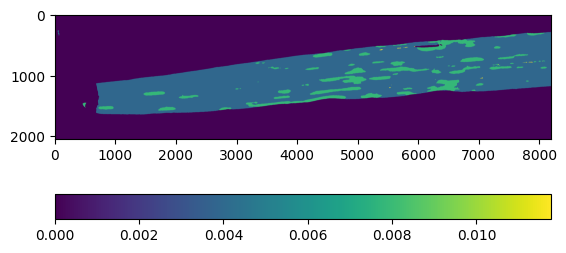

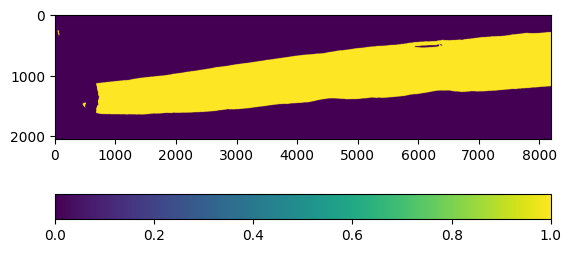

In [14]:
test = leaf.seg_masks[-1]
# test = np.array(test)
test = convert_image_to_tensor(test)
img = plt.imshow(K.tensor_to_image(test))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.show()
test[test!=0] = 1
img = plt.imshow(K.tensor_to_image(test))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.show()

mask shape: torch.Size([1, 1, 2048, 8192])
----------------
mask shape: torch.Size([1, 2048, 8192])
----------------
shapes: torch.Size([1, 2048]), torch.Size([1, 8192])
vals: tensor([False,  True]), tensor([False,  True])
----------------
shapes: torch.Size([1394]), torch.Size([7620])
vals: tensor([ 250,  251,  252,  ..., 1641, 1642, 1643]), tensor([  42,   43,   44,  ..., 8189, 8190, 8191])
----------------
tensor(250) tensor(1643)
tensor(42) tensor(8191)


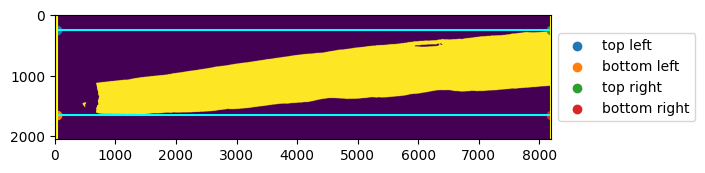

In [18]:
print(f"mask shape: {test.shape}")
print("----------------")

# mask = test.squeeze(0)
mask = torch.any(test != 0, dim=0)
print(f"mask shape: {mask.shape}")
print("----------------")

rows = torch.any(mask != 0, dim=2)
cols = torch.any(mask != 0, dim=1)
print(f"shapes: {rows.shape}, {cols.shape}")
print(f"vals: {torch.unique(rows)}, {torch.unique(cols)}")
print("----------------")

r_idx = torch.where(rows[0])[0]
c_idx = torch.where(cols[0])[0]
print(f"shapes: {r_idx.shape}, {c_idx.shape}")
print(f"vals: {torch.unique(r_idx)}, {torch.unique(c_idx)}")
print("----------------")

rmin, rmax = r_idx[0], r_idx[-1]
cmin, cmax = c_idx[0], c_idx[-1]

print(rmin, rmax)
print(cmin, cmax)

plt.imshow(K.tensor_to_image(test))
plt.scatter(cmin, rmin, label='top left')
plt.scatter(cmin, rmax, label='bottom left')
plt.scatter(cmax, rmin, label='top right')
plt.scatter(cmax, rmax, label='bottom right')
plt.hlines([rmin, rmax], 0, 8191, color='cyan')
plt.vlines([cmin, cmax], 0, 2047, color='yellow')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


cropped: torch.Size([1, 1, 1394, 8150])


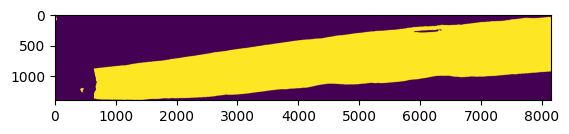

In [84]:
cropped = crop_img(test, cmin, cmax, rmin, rmax)
print(f"cropped: {cropped.shape}")
plt.imshow(K.tensor_to_image(cropped))

In [88]:
crop_coords_zero_borders(test)

(tensor(250), tensor(1643), tensor(42), tensor(8191))

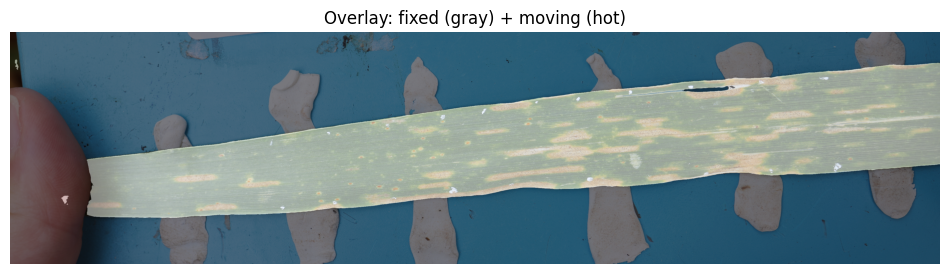

In [17]:
fig = plot_overlay(leaf.cropped_images[-1], test)

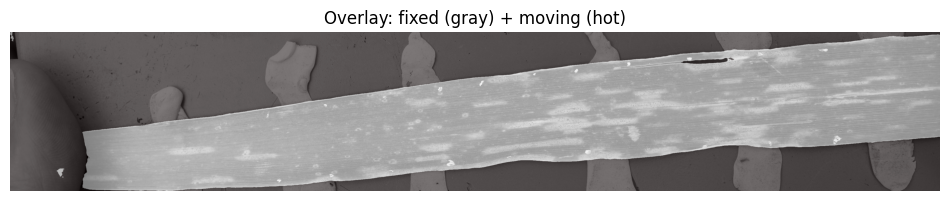

In [21]:
img = convert_image_to_tensor(leaf.cropped_images[-1])
cropped_mask = crop_img(test, cmin, cmax, rmin, rmax)
cropped_img = crop_img(img, cmin, cmax, rmin, rmax)
fig = plot_overlay(cropped_img, cropped_mask)

#### Erode

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

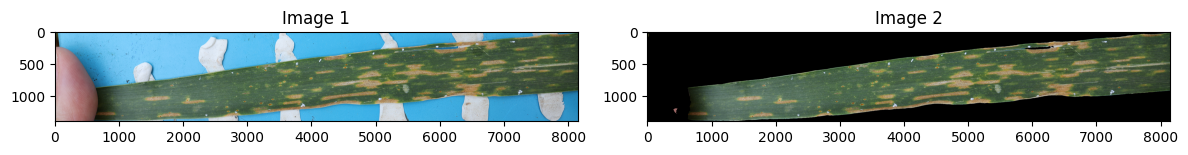

In [24]:
masked_img = cropped_img * cropped_mask
plot_image_pair(cropped_img, masked_img)

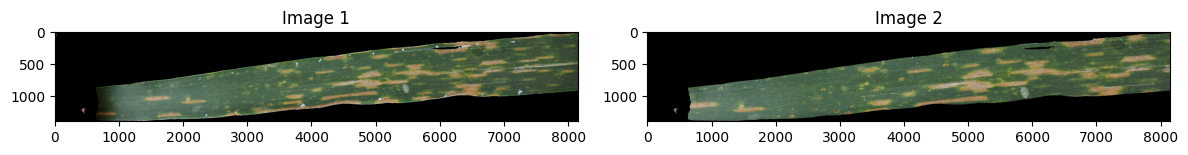

In [33]:
scaled_img = scale_image(masked_img, 1.3)
scaled_masked_img = scaled_img * cropped_mask
fig, axs = plot_image_pair(masked_img, scaled_masked_img)
fig.show()

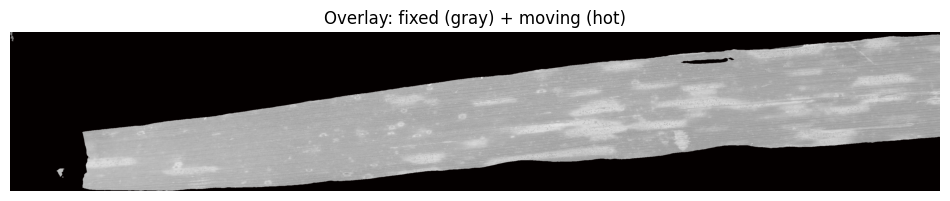

In [35]:
fig = plot_overlay(scaled_masked_img, cropped_mask)

### LoFTR + TPS Region Of Interest

In [ ]:
leaf.show_frame(12, show='images')

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

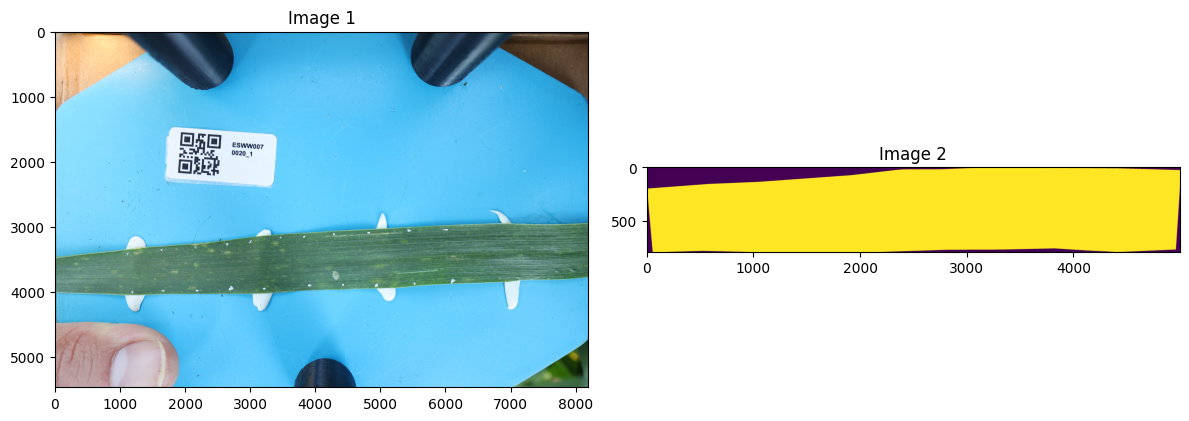

In [87]:
# ind = 1
ind = 2
og_leaf = convert_image_to_tensor(leaf.images[ind])
leaf_mask = convert_image_to_tensor(leaf.leaf_masks[ind])
plot_image_pair(og_leaf, leaf_mask)

5464 8192
[[ 9.98771767e-01 -4.95475242e-02  1.40394678e+02]
 [ 4.95475242e-02  9.98771767e-01 -1.99591127e+02]]


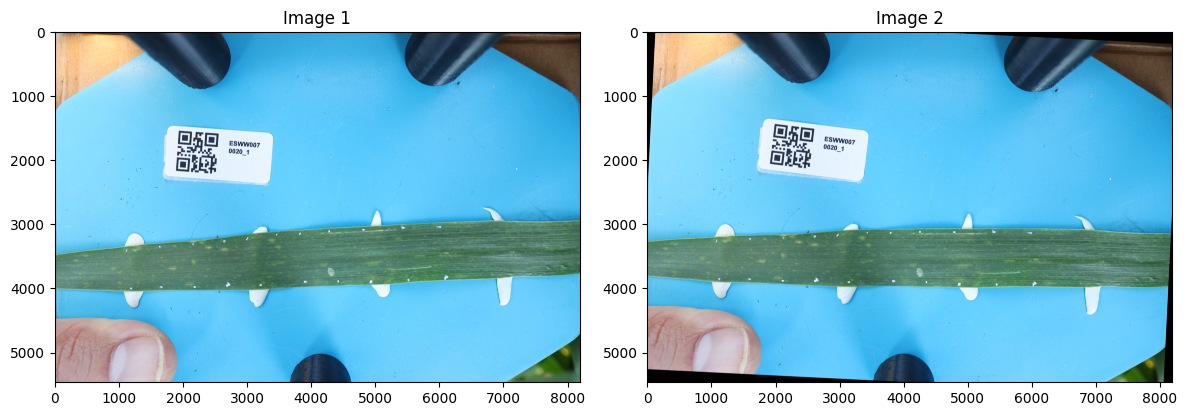

In [88]:
roi = leaf.rois[ind]
rot_mat = np.asarray(roi["rotation_matrix"])
bbox = np.asarray(roi["bounding_box"])
rows, cols = og_leaf.shape[0], og_leaf.shape[1]

leaf_np = K.tensor_to_image(og_leaf)
rows, cols = leaf_np.shape[0], leaf_np.shape[1]

print(rows, cols)
print(rot_mat)
img_rot_cv = cv2.warpAffine(leaf_np, rot_mat, (cols, rows))
_ = plot_image_pair(convert_image_to_tensor(leaf_np), convert_image_to_tensor(img_rot_cv))

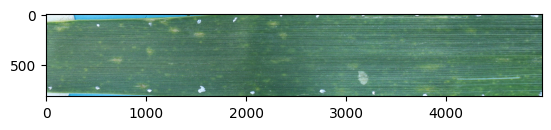

In [89]:
img_rot_cv_crop = img_rot_cv[bbox[0][1]:bbox[2][1], bbox[0][0]:bbox[1][0]]
plt.imshow(img_rot_cv_crop)

In [92]:
print(img_rot_cv_crop.shape)
print(convert_image_to_tensor(leaf.leaf_masks[ind]).shape)

(818, 4959, 3)
torch.Size([1, 1, 791, 4999])


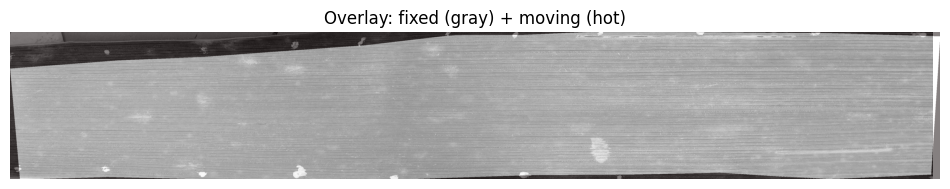

In [90]:
fig = plot_overlay(convert_image_to_tensor(img_rot_cv_crop), convert_image_to_tensor(leaf.leaf_masks[ind]))

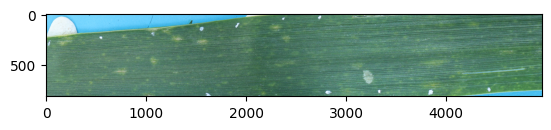

In [ ]:
# crop without rotate
img_crop = leaf_np[bbox[0][1]:bbox[2][1], bbox[0][0]:bbox[1][0]]
plt.imshow(img_crop)
# fig = plot_overlay(convert_image_to_tensor(img_crop), convert_image_to_tensor(leaf.leaf_masks[ind]))

In [ ]:
## From Dataset Tools

# rotate 
roi = self.rois[i]
M_img= np.asarray(roi["rotation_matrix"])
rows, cols = img.shape[0], img.shape[1]
img_rot = cv2.warpAffine(img, M_img, (cols, rows))

# crop
box = np.asarray(roi["bounding_box"])
crop = img_rot[box[0][1]:box[2][1], box[0][0]:box[1][0]]

#### Kornia

5464 8192
[[ 9.98771767e-01 -4.95475242e-02  1.40394678e+02]
 [ 4.95475242e-02  9.98771767e-01 -1.99591127e+02]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


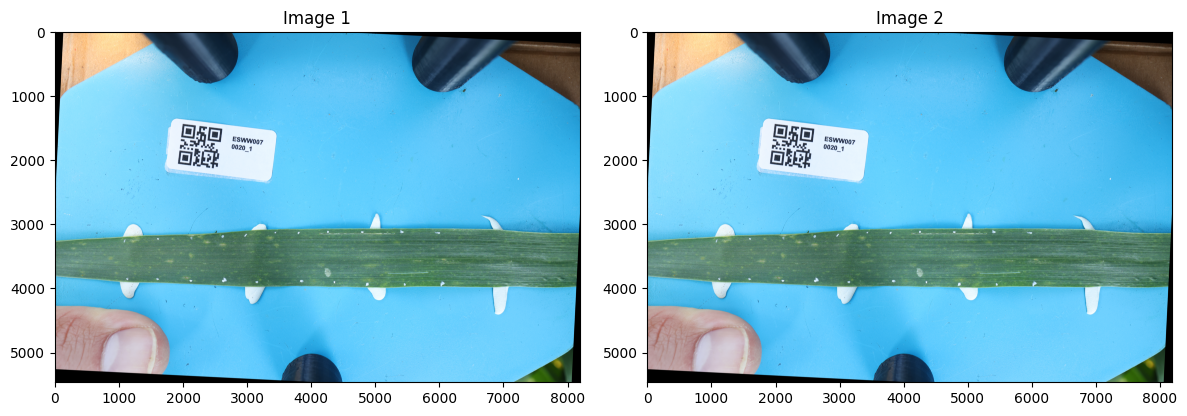

In [62]:
H, W = og_leaf.shape[2], og_leaf.shape[3]

print(rows, cols)
print(rot_mat)
img_rot_K = K.geometry.transform.warp_affine(og_leaf, torch.Tensor(rot_mat).unsqueeze(0), (H, W)) #, align_corners=True)
_ = plot_image_pair(convert_image_to_tensor(img_rot_K), convert_image_to_tensor(img_rot_cv))

torch.Size([1, 3, 5464, 8192])
torch.Size([1, 3, 5464, 8192])
213.6042 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..213.6042].


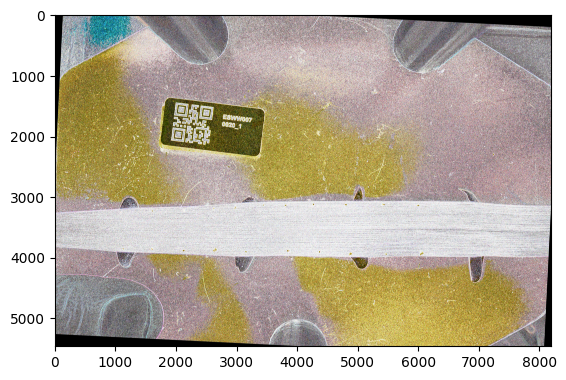

In [63]:
print(convert_image_to_tensor(img_rot_cv).shape)
print(img_rot_K.shape)
diff = torch.abs(img_rot_K-convert_image_to_tensor(img_rot_cv))
diff_img = K.tensor_to_image(diff)*255*51
print(diff_img.max(), diff_img.min())
plt.imshow(diff_img)
# torch.sum(torch.abs(img_rot_K-convert_image_to_tensor(img_rot_cv)))

In [103]:
print(bbox)
print(bbox[:,0].max())

[[1086 3124]
 [6045 3124]
 [6045 3942]
 [1086 3942]]
6045


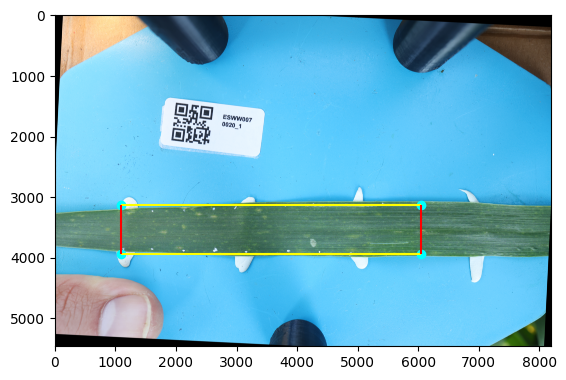

In [101]:
plt.imshow(img_rot_cv)
plt.hlines(y=[3124, 3942], xmin=1086, xmax=6045, color='yellow')
plt.vlines(x=[1086, 6045], ymin=3124, ymax=3942, color='red')
plt.scatter(bbox[:,0], bbox[:,1], color='cyan')

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

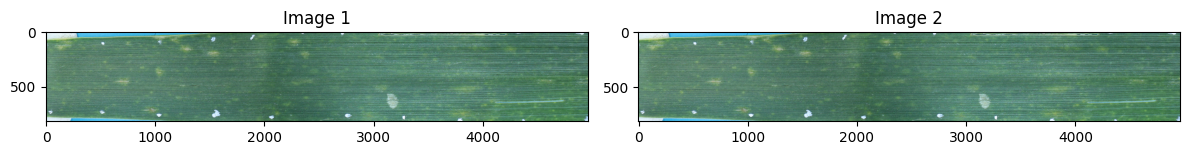

In [ ]:
img_rot_K_crop = crop_img(img_rot_K, bbox[:,0].min(), bbox[:,0].max(), bbox[:,1].min(), bbox[:,1].max())
fig, ax = plot_image_pair(img_rot_K_crop, convert_image_to_tensor(img_rot_cv_crop))

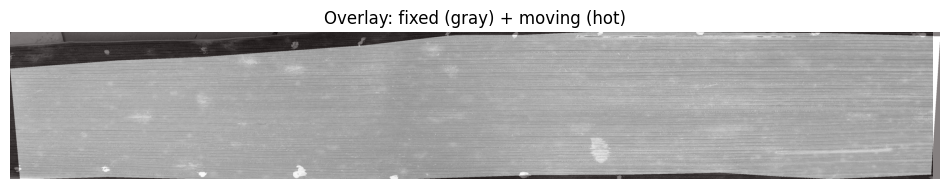

In [105]:
fig = plot_overlay(img_rot_K_crop, convert_image_to_tensor(leaf.leaf_masks[ind]))

In [106]:
print(img_rot_K_crop.shape)
print(convert_image_to_tensor(leaf.leaf_masks[ind]).shape)

torch.Size([1, 3, 819, 4960])
torch.Size([1, 1, 791, 4999])


## Evaluation Metrics

### IoU

In [ ]:
pred = convert_image_to_tensor(moving_mask).long()
target = convert_image_to_tensor(fixed_mask).long()

print("Pred unique:", torch.unique(pred))
print("Target unique:", torch.unique(target))

print("Pred counts:", torch.bincount(pred.flatten()))
print("Target counts:", torch.bincount(target.flatten()))

Pred unique: tensor([0, 1])
Target unique: tensor([0, 1])
Pred counts: tensor([ 258061, 1003934])
Target counts: tensor([310924, 951071])
Equal masks: False


In [8]:
print(iou(None, fixed_mask, None, moving_mask).item())
print(iou(None, fixed_mask, None, fixed_mask).item())

0.9106493592262268
1.0


IoU of background is smaller than IoU of foreground/leaf $=>$ relativ to total number of background pixels, more false positives. BUT background is smaller than foreground. IoU punishes smaller class more harshly for boundary errors.

### MSE

In [75]:
# sanity check
print(f"Standard MSE: {mse(fixed, moving)}")
print(f"'Masked' MSE: {mse_masked(fixed, torch.ones_like(convert_image_to_tensor(fixed)), moving, torch.ones_like(convert_image_to_tensor(moving)))}")

print(f"Masked MSE: {mse_masked(fixed, fixed_mask, moving, moving_mask)}")

Standard MSE: 0.01612808369100094
'Masked' MSE: 0.01612808369100094
Masked MSE: 0.017626041546463966


### NCC

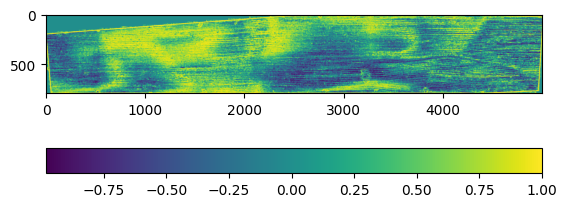

In [47]:
res = local_ncc(fixed, moving, reduction='none')
img = plt.imshow(K.tensor_to_image(res))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.show()

In [136]:
# sanity check
print(f"Standard NCC: {ncc(fixed, moving)}")
print(f"'Masked' NCC: {ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")
print(f"Inverted Images: {ncc(img1, img2)}")
print(f"Blackened Images: {ncc(img3, img4)}")

print(f"Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask)}")
print(f"'and' Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask, mask_mode='both')}")

Standard NCC: 0.8246079683303833
'Masked' NCC: 0.8246080279350281
Inverted Images: 0.9106995463371277
Blackened Images: 0.956824004650116
Masked NCC: 0.3901742696762085
'and' Masked NCC: 0.3908914029598236


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

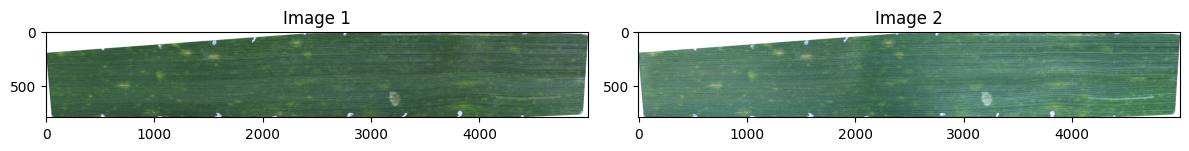

In [123]:
img1 = convert_image_to_tensor(fixed)
img2 = convert_image_to_tensor(moving)
img1[K.color.grayscale_to_rgb(fixed_mask) == 0] = 1
img2[K.color.grayscale_to_rgb(moving_mask) == 0] = 1
plot_image_pair(img1, img2)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

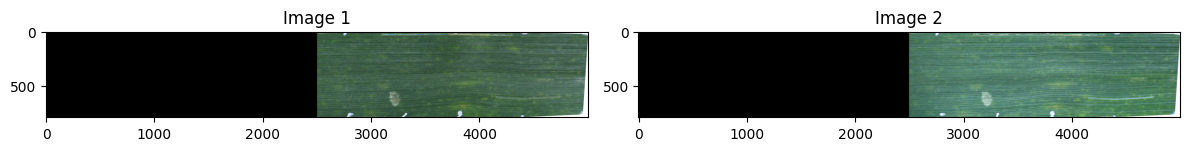

In [135]:
img3 = img1.clone()
img4 = img2.clone()
img3[0,:,:,:2500] = 0
img4[0,:,:,:2500] = 0
plot_image_pair(img3, img4)

#### Local NCC

In [111]:
# sanity check
print(f"Standard LNCC: {local_ncc(fixed, moving)}")
print(f"'Masked' LNCC: {local_ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")

print(f"Masked LNCC: {local_ncc_masked(fixed, fixed_mask, moving, moving_mask)}")

test
Standard LNCC: 0.17045828700065613
'Masked' LNCC: 0.16544589400291443
Masked LNCC: 0.15299779176712036


### Mutual Information

In [6]:
# sanity check
print(f"Old MI: {mutual_information(fixed, moving)}")
print(f"Skimage NMI: {nmi_skimage(fixed, moving)}")
print(f"New MI: {nmi(fixed, moving)}")
print(f"'Masked' MI: {nmi_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")
print(f"Masked MI: {nmi_masked(fixed, fixed_mask, moving, moving_mask)}")
print(f"Masked MI of same image: {nmi_masked(fixed, fixed_mask, fixed, fixed_mask)}")
print(f"New MI of same image: {nmi(fixed, fixed)}")
print(f"Skimage NMI of same image: {nmi_skimage(fixed, fixed)}")
print(f"Old MI of same image: {mutual_information(fixed, fixed)}")

Old MI: 0.3668353259563446
Skimage NMI: 1.0775757784357562
New MI: 1.0758801698684692
'Masked' MI: 1.07589852809906
Masked MI: 1.0123107433319092
Masked MI of same image: 1.1134573221206665
New MI of same image: 1.1742256879806519
Skimage NMI of same image: 2.0
Old MI of same image: 3.190188407897949


In [77]:
for sigma in [0.1, 0.05, 0.02, 0.01]:
    print(nmi(fixed, fixed, sigma=sigma))

0.1
tensor(1.0570)
0.05
tensor(1.1512)
0.02
tensor(1.3409)
0.01
tensor(1.6236)


In [79]:
print(nmi(fixed, fixed, bins=32, sigma_ratio=0.5))
print(nmi(fixed, fixed, bins=64, sigma_ratio=0.5))

tensor(0.0161)
tensor(1.4153)
tensor(0.0079)
tensor(1.4938)


In [69]:
def parzen_kernel(x: torch.Tensor):
    x = torch.abs(x)

    return torch.where(
        x < 0.5,
        -1.8 * x**2 - 0.1 * x + 1,
        torch.where(
            x <= 1,
            1.8 * x**2 - 3.7 * x + 1.9,
            torch.zeros_like(x)
        )
    )

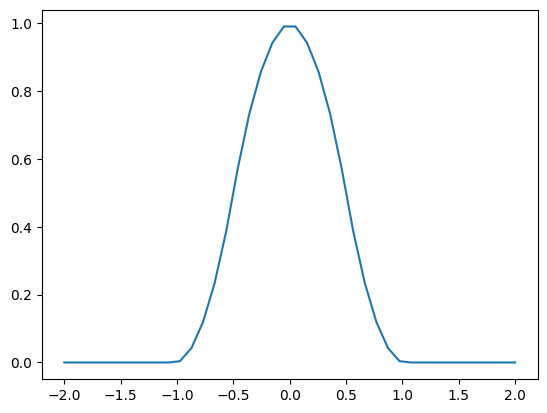

In [70]:
x = torch.linspace(-2, 2, 40)
out = parzen_kernel(x)
plt.plot(x, out)
plt.show()

In [75]:
def nmi(img1, img2, reduction="mean", bins=32, sigma_ratio=1.0, sigma=None, eps=1e-13):
    """
    Parzen-window Normalized Mutual Information (NMI)

    A, B : tensors of same shape, intensities in [0,1]
    W    : same shape, 1 = valid pixel, 0 = invalid
    bins : number of Parzen bins
    sigma: Gaussian kernel width

    Returns: scalar NMI
    """

    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)

    # Convert to grayscale
    img1 = K.color.rgb_to_grayscale(img1)
    img2 = K.color.rgb_to_grayscale(img2)

    # flatten
    img1 = img1.reshape(-1)
    img2 = img2.reshape(-1)

    device = img1.device

    # bin centers
    # shape: (1, bins)
    bin_centers = torch.linspace(0.0, 1.0, bins, device=device).unsqueeze(0)
    bin_width = torch.mean(torch.diff(bin_centers))
    if sigma is None:
        sigma = bin_width * sigma_ratio

    print(sigma)

    # Parzen soft assignment
    # shape: (N, bins)
    img1 = img1.unsqueeze(1)
    img2 = img2.unsqueeze(1)

    hist1 = torch.exp(-(img1 - bin_centers)**2 / (2 * sigma**2))
    hist2 = torch.exp(-(img2 - bin_centers)**2 / (2 * sigma**2))

    # hist1 = parzen_kernel(img1 - bin_centers)
    # hist2 = parzen_kernel(img2 - bin_centers)


    # normalize kernels
    hist1 = hist1 / (hist1.sum(dim=1, keepdim=True) + eps)
    hist2 = hist2 / (hist2.sum(dim=1, keepdim=True) + eps)
    # print(f"P1 alt: {torch.mean(hist1, dim=0)}")

    # joint Parzen histogram
    # shape: (bins, bins)
    P12 = hist1.T @ hist2
    
    # normalize to probabilities
    P12 = P12 / (P12.sum() + eps)

    # marginals
    P1 = torch.mean(hist1, dim=0)
    P2 = torch.mean(hist2, dim=0)    

    # entropies
    H1  = -(P1  * torch.log(P1  + eps)).sum()
    H2  = -(P2  * torch.log(P2  + eps)).sum()
    H12 = -(P12 * torch.log(P12 + eps)).sum()
    # print("--------------------")
    # print(H1)
    # print(H12)
    

    # normalized mutual information
    NMI = (H1 + H2) / H12

    return NMI


In [81]:
print(nmi(fixed, fixed, bins=64, sigma=0.01)) # target: 1.7–1.9
print(nmi(fixed, fixed, bins=32, sigma=0.02)) # target: 1.5–1.8
print(nmi(fixed, fixed, bins=32, sigma=0.05)) # target: 1.2–1.4

0.01
tensor(1.4152)
0.02
tensor(1.3409)
0.05
tensor(1.1512)


In [12]:
# identical vs random
print(nmi(fixed, fixed))
print(nmi(fixed, torch.randn_like(fixed)))

tensor(1.1742)
tensor(0.8343)


### SSIM

In [4]:
def ssim_masked(img1, img1_mask, img2, img2_mask, window_size=11, reduction='mean'):
    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)


    ssim_map = K.metrics.ssim(img1, img2, window_size, eps=1e-12, padding='same', max_val=1.0)
    if reduction == 'mean':
        return ssim_map.mean(dim=(1, 2, 3))
    elif reduction == 'none':
        return ssim_map
    else:
        raise ValueError("reduction must be either 'mean' or 'none'")


In [23]:
ksim = ssim_kornia(fixed, moving, reduction='mean')
ksim_img = ssim_kornia(fixed, moving, reduction='none').squeeze(0)
skisim, skisim_img = ssim_skimage(fixed, moving, return_img=True)
skisim_img = convert_image_to_tensor(skisim_img)
print(f"Kornia SSIM: {ksim}")
print(f"Skimage SSIM: {skisim}")
print(f"Diff: {ksim-skisim}")
print(f"Kornia SSIM Image: {ksim_img.shape}")
print(f"Skimage SSIM Image: {skisim_img.shape}")
print(f"Diff: {torch.mean(ksim_img-skisim_img)}")

Kornia SSIM: 0.432451456785202
Skimage SSIM: 0.4262583553791046
Diff: 0.006193101406097412
Kornia SSIM Image: torch.Size([3, 791, 4999])
Skimage SSIM Image: torch.Size([3, 791, 4999])
Diff: 0.0011111005442216992


### Hausdorff Distance

In [10]:
print(hausdorff(None, fixed_mask, None, moving_mask).item())
print(hausdorff(None, fixed_mask, None, fixed_mask).item())

169.85818481445312
0.0


95%-Hausdorff distance = the distance such that 95\% of boundary points from the predicted (moving) mask are within that distance to the ground truth boundary (and vice versa).

=> “What is the typical worst-case boundary error?”

## Evaluation

In [12]:
out_file = "registration_eval2.csv"

METHODS = ["Pairwise Affine", "LoFTR + TPS ROI", "LoFTR + TPS ROI with Markers"]
data_to_load = []
if "Pairwise Affine" in METHODS:
    data_to_load.extend(['target_images', 'target_masks'])
if "LoFTR + TPS ROI" in METHODS or "LoFTR + TPS ROI with Markers" in METHODS:
    data_to_load.extend(['rois', 'images', 'keypoints', 'leaf_masks'])
if "LoFTR + TPS Full" in METHODS or "LoFTR + TPS Full with Markers" in METHODS:
    data_to_load.extend(['seg_masks', 'cropped_images'])

metrics = {'MSE': mse_masked, 'NCC': local_ncc_masked, 'MI': nmi_masked, 'SSIM': ssim_masked, 'IoU': iou, 'Hausdorff': hausdorff}

# processed_uids = set()
processed_keys = set()

if os.path.exists(out_file):
    with open(out_file, newline="", mode="r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            # if row['registration_method'] == METHOD:
            #     processed_uids.add(row['leaf_uid'])

            key = (row["leaf_uid"], row["registration_method"])
            processed_keys.add(key)

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['leaf_uid', 'registration_method', 'fixed_image', 'moving_image']+list(metrics.keys()))
    
    # write header only if file is new
    if f.tell() == 0:
        writer.writeheader()

    for uid in leaf_uids:
        # if uid in processed_uids:
        #         print(f"Leaf {uid} has already been evaluated for {METHOD} registration")
        #         continue

        keys_to_check = [ (uid, method) for method in METHODS ]

        if all(key in processed_keys for key in keys_to_check):
            print(f"Leaf {uid} has been processed for all registration methods")
            continue
        
        leaf = LeafDataset(
            base_dir=base_dir,
            leaf_uid=uid, 
            load=(data_to_load),
            verbose=False
        )  

        fixed_img_indices = [0] #,1]
        moving_img_indices = np.arange(1,len(leaf.image_uids))

        for method in METHODS:
            key = (uid, method)
            if key in processed_keys:
                print(f"Leaf {uid} has already been evaluated for {method} registration.")
                continue
            else:
                print(f"Evaluating {method} registration on leaf {uid}...")

            for fixed_img_ind in fixed_img_indices:
                for moving_img_ind in tqdm(moving_img_indices):

                    fixed_img, moving_img, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, fixed_img_ind, moving_img_ind, method)
                    
                    eval_res = {'leaf_uid': uid, 'registration_method': method, 'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind}

                    if (fixed_img is None) or (moving_img is None) or (fixed_mask is None) or (moving_mask is None):
                        print(f"Error: missing data for leaf {uid}")
                        for metric_name, metric_func in metrics.items():
                            eval_res.update({metric_name: None})    
                        writer.writerow(eval_res)
                        continue                    

                    # metric_vals = {}
                    for metric_name, metric_func in metrics.items():
                        val = metric_func(fixed_img, fixed_mask, moving_img, moving_mask)
                        # metric_vals.update({metric_name: val})
                        eval_res.update({metric_name: val.item()})

                    # eval_res.update(metric_vals)
                    writer.writerow(eval_res)

                    

Leaf ESWW0070020_1 has already been evaluated for Pairwise Affine registration.
Leaf ESWW0070020_1 has already been evaluated for LoFTR + TPS ROI registration.
Evaluating LoFTR + TPS ROI with Markers registration on leaf ESWW0070020_1...


  0%|          | 0/13 [00:00<?, ?it/s]

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /home/renku/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:00<00:00, 148MB/s]
100%|██████████| 13/13 [09:07<00:00, 42.13s/it]


Leaf ESWW0070020_10 has already been evaluated for Pairwise Affine registration.
Leaf ESWW0070020_10 has already been evaluated for LoFTR + TPS ROI registration.
Evaluating LoFTR + TPS ROI with Markers registration on leaf ESWW0070020_10...


100%|██████████| 13/13 [03:26<00:00, 15.88s/it]


Leaf ESWW0070020_2 has already been evaluated for Pairwise Affine registration.
Leaf ESWW0070020_2 has already been evaluated for LoFTR + TPS ROI registration.
Evaluating LoFTR + TPS ROI with Markers registration on leaf ESWW0070020_2...


100%|██████████| 14/14 [06:59<00:00, 29.99s/it]


Leaf ESWW0070020_3 has already been evaluated for Pairwise Affine registration.
Leaf ESWW0070020_3 has already been evaluated for LoFTR + TPS ROI registration.
Evaluating LoFTR + TPS ROI with Markers registration on leaf ESWW0070020_3...


100%|██████████| 13/13 [06:51<00:00, 31.69s/it]


OSError: [Errno 107] Transport endpoint is not connected

## Visualization

In [5]:
df_full = pd.read_csv("registration_eval2.csv")
df_full.head()

leaf_uid registration_method  fixed_image  moving_image       MSE  \
0  ESWW0070020_1     Pairwise Affine            0             1  0.006813   
1  ESWW0070020_1     Pairwise Affine            0             2  0.024689   
2  ESWW0070020_1     Pairwise Affine            0             3  0.010441   
3  ESWW0070020_1     Pairwise Affine            0             4  0.033797   
4  ESWW0070020_1     Pairwise Affine            0             5  0.035394   

        NCC        MI      SSIM       IoU  Hausdorff  
0  0.015722  1.009170  0.313402  0.948756  56.320511  
1  0.010441  1.005553  0.238523  0.948640  56.320511  
2  0.018857  1.005519  0.256883  0.948681  56.320511  
3  0.022684  1.006689  0.213784  0.948755  56.320511  
4 -0.009654  1.004894  0.209419  0.948741  56.320511

In [6]:
n_uids = df_full['leaf_uid'].nunique()
print(f"Number of leafs evaluated: {n_uids}")

Number of leafs evaluated: 32


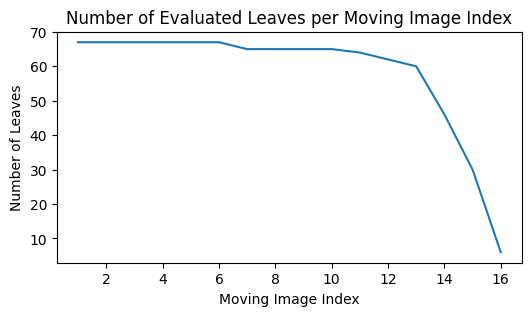

In [7]:
moving_img_ind_count = df_full['moving_image'].value_counts()
plt.figure(figsize=(6, 3))
plt.plot(moving_img_ind_count.index, moving_img_ind_count.values)
plt.title("Number of Evaluated Leaves per Moving Image Index")
plt.xlabel("Moving Image Index")
plt.ylabel("Number of Leaves")
plt.show()

In [13]:
metrics = ["MSE", "NCC", "MI", "SSIM", "IoU", "Hausdorff"]
group_cols = ['registration_method', 'fixed_image', 'moving_image']
methods = df_full["registration_method"].unique()


In [12]:
# average over leaf series for each index pair
df_agg = df_full.groupby(group_cols)[metrics].agg(["mean", "std"]).reset_index()
df_agg.columns = [ "_".join(col).rstrip("_") for col in df_agg.columns ]
df_agg.sample(5).sort_values(by=(['registration_method', 'fixed_image', 'moving_image']))

registration_method  fixed_image  moving_image  MSE_mean  \
2                LoFTR + TPS ROI            0             3  0.013648   
15               LoFTR + TPS ROI            0            16  0.031732   
26  LoFTR + TPS ROI with Markers            0            11  0.033599   
32               Pairwise Affine            0             3  0.015363   
39               Pairwise Affine            0            10  0.025460   

     MSE_std  NCC_mean   NCC_std   MI_mean    MI_std  SSIM_mean  SSIM_std  \
2   0.006946  0.125316  0.189694  1.012587  0.012840   0.407409  0.111562   
15  0.007077  0.090849  0.157843  1.004738  0.007496   0.459312  0.070183   
26  0.006125  0.018834  0.014833  1.004572  0.004574   0.312969  0.091940   
32  0.006951  0.107112  0.066251  1.016807  0.006764   0.333517  0.070230   
39  0.019224  0.071101  0.062615  1.009814  0.005478   0.314600  0.072762   

    IoU_mean   IoU_std  Hausdorff_mean  Hausdorff_std  
2   0.922937  0.063708       43.716262      39.206717  
15  0.679726  0.240199      174.826654     128.983665  
26  0.798881  0.087026      176.886482      79.788784  
32  0.923305  0.022211       84.116306      55.136412  
39  0.906302  0.052142      135.686570     165.800325

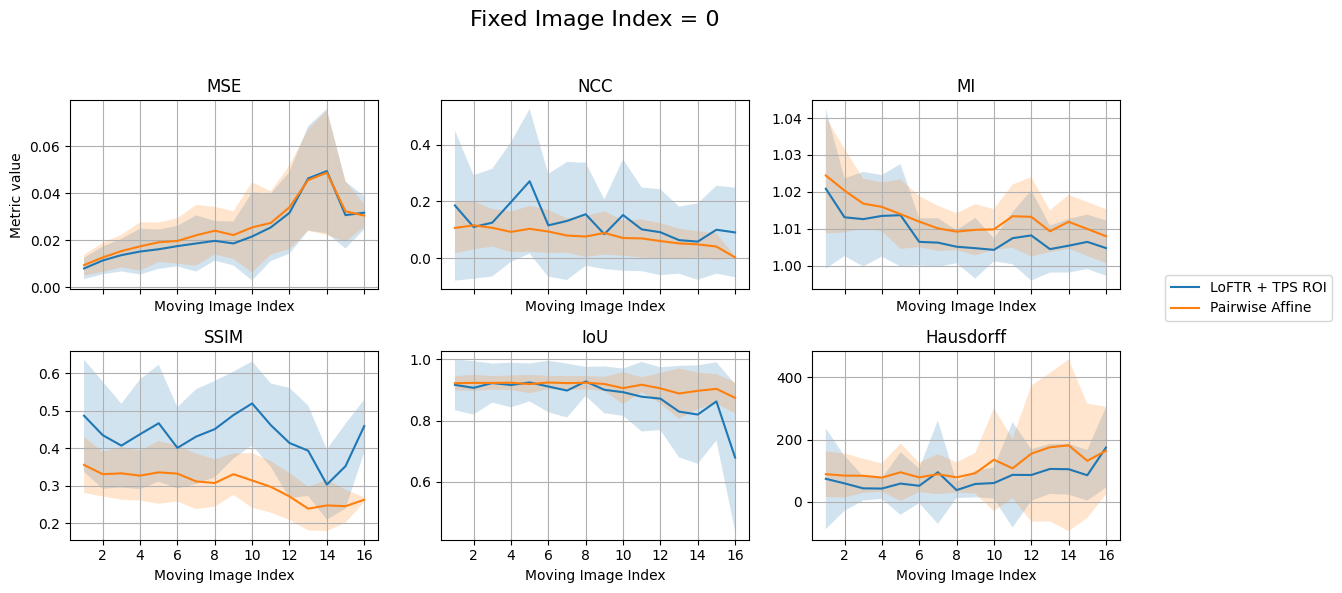

In [22]:
methods = ["LoFTR + TPS ROI", "Pairwise Affine"]
n_metrics = len(metrics)

n_rows = 2
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for method in methods:
        df_plot = df_agg[
            (df_agg["fixed_image"] == 0) &
            (df_agg["registration_method"] == method) &
            (df_agg["moving_image"] != 0)
        ].sort_values("moving_image")

        if df_plot.empty:
            continue

        x = df_plot["moving_image"]
        mean = df_plot[f"{metric}_mean"]
        std = df_plot[f"{metric}_std"]

        ax.plot(x, mean, label=method)
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, label="_nolegend_")

    ax.set_title(metric)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Moving Image Index")

# hide unused subplots
for ax in axes[len(metrics):]:
    ax.set_visible(False)

# shared y-label
axes[0].set_ylabel("Metric value")

# put legend far right outside
fig.legend(
    methods,
    loc="center right",
    bbox_to_anchor=(1.12, 0.5)
)

fig.suptitle("Fixed Image Index = 0", fontsize=16)

# tighten layout to remove empty space
fig.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


### Distribution over leaves (averages over moving image index)

In [24]:
# average over leaf series over each index pair
df_agg_leaf = df_full.groupby(['leaf_uid', 'registration_method'])[metrics].agg(["mean", "std"]).reset_index()
df_agg_leaf.columns = [ "_".join(col).rstrip("_") for col in df_agg_leaf.columns ]
df_agg_leaf.sample(5).sort_values(by=(['registration_method']))

leaf_uid registration_method  MSE_mean   MSE_std  NCC_mean   NCC_std  \
53  ESWW0070025_6     LoFTR + TPS ROI  0.018474  0.014695  0.093071  0.122214   
16  ESWW0070020_6     LoFTR + TPS ROI  0.019651  0.013791  0.184675  0.217528   
43  ESWW0070025_1     LoFTR + TPS ROI  0.027605  0.026299  0.071025  0.042043   
13  ESWW0070020_4     Pairwise Affine  0.011819  0.006462  0.056361  0.047706   
35  ESWW0070023_5     Pairwise Affine  0.024173  0.015538  0.059213  0.037820   

     MI_mean    MI_std  SSIM_mean  SSIM_std  IoU_mean   IoU_std  \
53  1.006289  0.004485   0.429537  0.129951  0.888626  0.039590   
16  1.014391  0.014301   0.488346  0.129760  0.923546  0.072767   
43  1.004741  0.003730   0.419990  0.106499  0.942925  0.047959   
13  1.013194  0.005992   0.420714  0.092358  0.950884  0.000062   
35  1.015878  0.010866   0.323532  0.066572  0.950438  0.000188   

    Hausdorff_mean  Hausdorff_std  
53      115.818312     104.344453  
16       50.885823      47.939527  
43       41.155744      40.572885  
13       79.404030       0.000000  
35       72.000000       0.000000

In [25]:
df_agg_leaf_melt = df_agg_leaf.melt(id_vars=['leaf_uid','registration_method'], value_vars=['MSE_mean', 'NCC_mean', 'MI_mean', 'SSIM_mean', 'IoU_mean', 'Hausdorff_mean'],)
df_agg_leaf_melt.sample(5)

leaf_uid           registration_method        variable       value
399  ESWW0070040_10               Pairwise Affine  Hausdorff_mean  144.406867
394   ESWW0070025_9               LoFTR + TPS ROI  Hausdorff_mean  125.060638
275   ESWW0070020_2  LoFTR + TPS ROI with Markers        IoU_mean    0.702552
137  ESWW0070020_10               LoFTR + TPS ROI         MI_mean    1.010271
297   ESWW0070023_2               Pairwise Affine        IoU_mean    0.916552

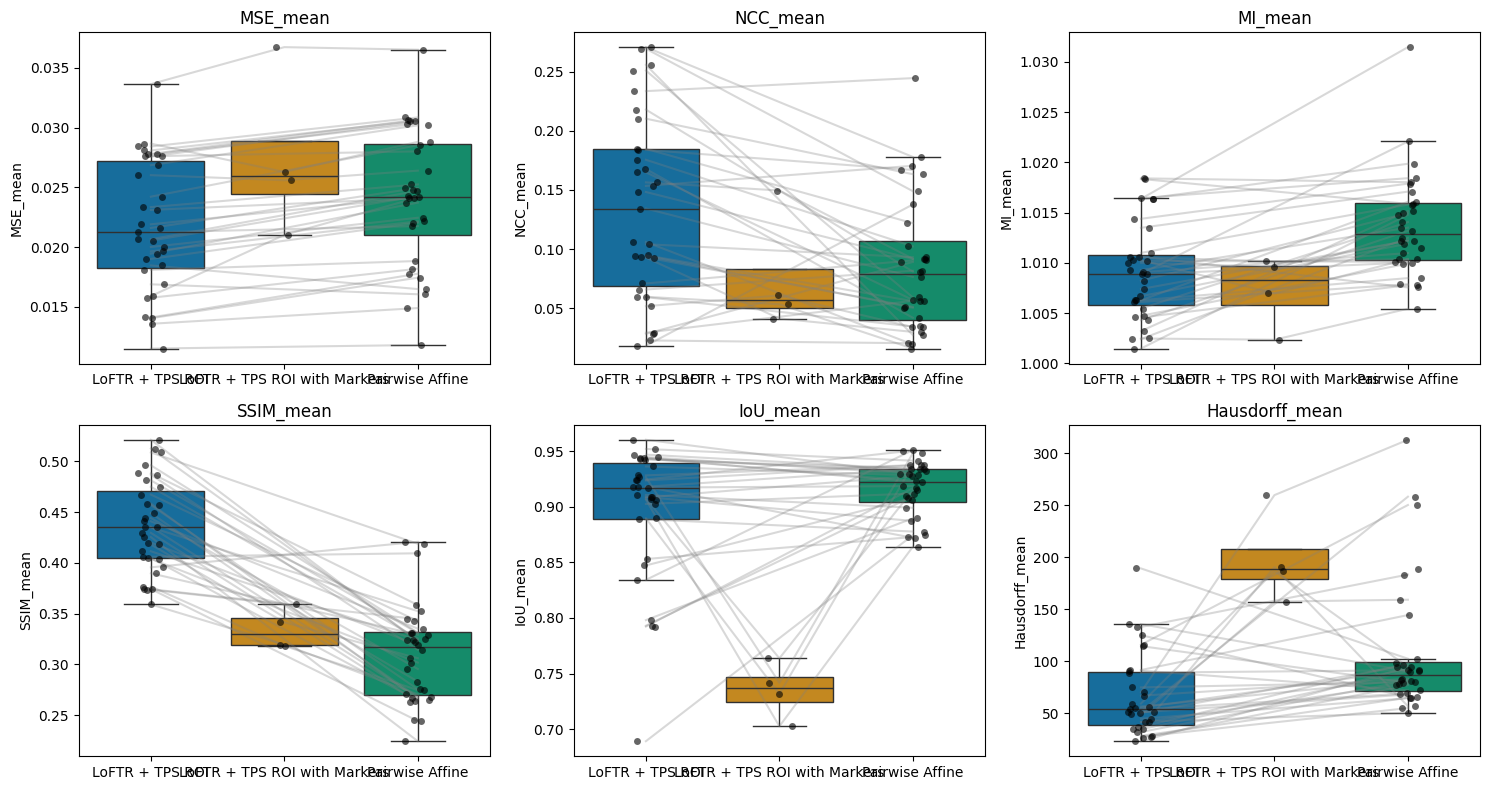

In [26]:
def plot_metrics_boxplots(df, metrics, method_col="registration_method", value_col="value", id_col="leaf_uid", plot_lines=False):
    n_metrics = len(metrics)

    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(15, 8),
        sharey=False
    )

    axes = axes.flatten()

    methods = df[method_col].unique()
    palette = dict(zip(methods, sns.color_palette("colorblind", len(methods))))

    for ax, metric in zip(axes, metrics):
        data_m = df[df["variable"] == metric]

        sns.boxplot(
            data=data_m,
            x=method_col,
            y=value_col,
            ax=ax,
            hue=method_col,
            palette=palette,
            showfliers=False
        )

        sns.stripplot(
            data=data_m,
            x=method_col,
            y=value_col,
            ax=ax,
            color="black",
            alpha=0.6,
            jitter=True
        )

        if plot_lines:
            sns.lineplot(
                data=data_m,
                x=method_col,
                y=value_col,
                units="leaf_uid",
                estimator=None,
                color="gray",
                alpha=0.3,
                ax=ax
            )


        ax.set_title(metric)
        ax.set_xlabel("")
        ax.set_ylabel(metric)

    # Remove unused axes if metrics < grid size
    for ax in axes[len(metrics):]:
        ax.remove()

    plt.tight_layout()
    plt.show()

plot_metrics_boxplots(df_agg_leaf_melt, [metric + "_mean" for metric in metrics], plot_lines=True)

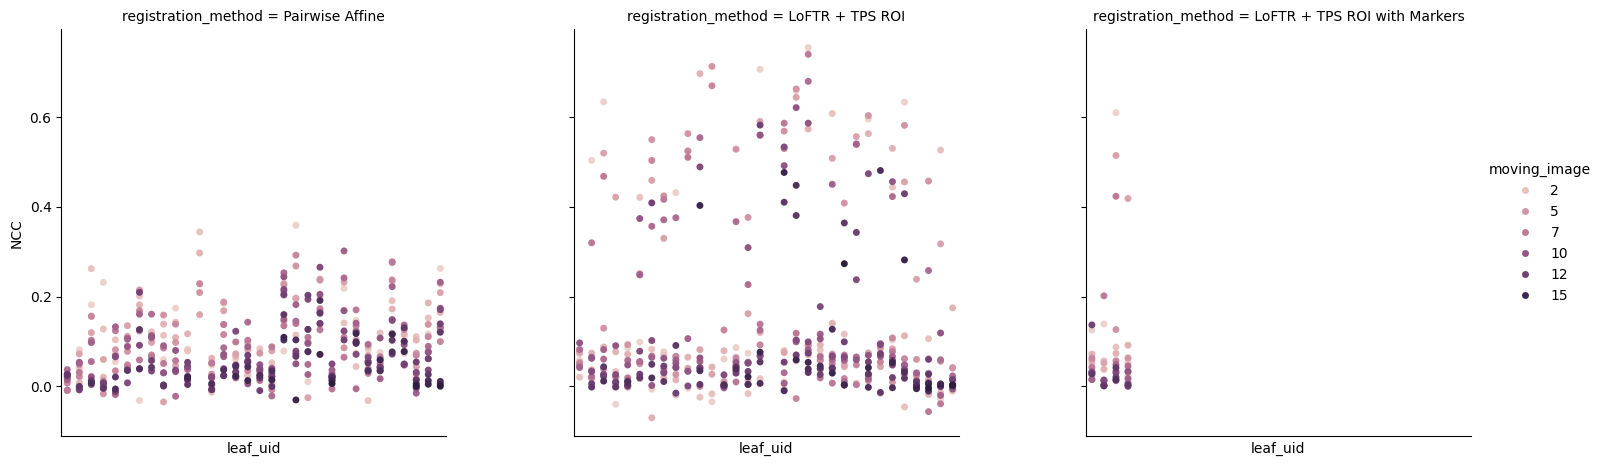

In [29]:
sns.catplot(data=df_full, x="leaf_uid", y="NCC", jitter=False, hue="moving_image", native_scale=True, col="registration_method")
plt.xticks([])
plt.show()

### Worst Performance

In [35]:
df_flagged = df_agg_leaf.copy()
df_flagged["bad"] = (
    df_flagged
    .groupby("registration_method")["Hausdorff_mean"]
    .rank(method="first", ascending=False)
    <= 10
)
df_flagged[df_flagged["bad"]][['leaf_uid', 'registration_method', 'Hausdorff_mean']].sort_values(by=["Hausdorff_mean"], ascending=[False]).head(7)

leaf_uid           registration_method  Hausdorff_mean
8   ESWW0070020_2               Pairwise Affine      313.099718
7   ESWW0070020_2  LoFTR + TPS ROI with Markers      259.836291
56  ESWW0070025_7               Pairwise Affine      258.327271
54  ESWW0070025_6               Pairwise Affine      250.314862
1   ESWW0070020_1  LoFTR + TPS ROI with Markers      190.493446
65  ESWW0070040_2               LoFTR + TPS ROI      189.291399
36  ESWW0070023_6               Pairwise Affine      188.984180

In [31]:
bad_counts = (
    df_flagged[df_flagged["bad"]]
    .groupby("leaf_uid")["registration_method"]
    .nunique()
)

leaves_bad_in_one_method = bad_counts[bad_counts == 1].index#.tolist()

df_flagged[
    (df_flagged["bad"]) &
    (df_flagged["leaf_uid"].isin(leaves_bad_in_one_method))
][["leaf_uid", "registration_method", "Hausdorff_mean"]].sort_values(by=["Hausdorff_mean"], ascending=False)


leaf_uid           registration_method  Hausdorff_mean
56   ESWW0070025_7               Pairwise Affine      258.327271
1    ESWW0070020_1  LoFTR + TPS ROI with Markers      190.493446
36   ESWW0070023_6               Pairwise Affine      188.984180
4   ESWW0070020_10  LoFTR + TPS ROI with Markers      186.549997
28   ESWW0070023_2               LoFTR + TPS ROI      135.721642
59   ESWW0070025_9               LoFTR + TPS ROI      125.060638
12   ESWW0070020_4               LoFTR + TPS ROI      114.547656
27  ESWW0070023_10               Pairwise Affine       98.057760
25   ESWW0070023_1               Pairwise Affine       96.436785
34   ESWW0070023_5               LoFTR + TPS ROI       90.942395
61   ESWW0070040_1               LoFTR + TPS ROI       88.957162
32   ESWW0070023_4               LoFTR + TPS ROI       74.813625

### Inspection

In [46]:
uid = "ESWW0070023_10" #"ESWW0070025_7" "ESWW0070020_2"
df_full[df_full['leaf_uid'] == uid].sort_values(by=['Hausdorff', 'IoU'], ascending=[False, True])

leaf_uid registration_method  fixed_image  moving_image       MSE  \
291  ESWW0070023_10     Pairwise Affine            0             3  0.026432   
297  ESWW0070023_10     LoFTR + TPS ROI            0             3  0.026121   
292  ESWW0070023_10     Pairwise Affine            0             4  0.012062   
290  ESWW0070023_10     Pairwise Affine            0             2  0.009582   
294  ESWW0070023_10     Pairwise Affine            0             6  0.012778   
293  ESWW0070023_10     Pairwise Affine            0             5  0.020330   
289  ESWW0070023_10     Pairwise Affine            0             1  0.008278   
296  ESWW0070023_10     LoFTR + TPS ROI            0             2  0.010657   
298  ESWW0070023_10     LoFTR + TPS ROI            0             4  0.010853   
299  ESWW0070023_10     LoFTR + TPS ROI            0             5  0.017420   
295  ESWW0070023_10     LoFTR + TPS ROI            0             1  0.008031   
300  ESWW0070023_10     LoFTR + TPS ROI            0             6  0.008476   

          NCC        MI      SSIM       IoU   Hausdorff  
291  0.297080  1.019279  0.385791  0.894820  238.346558  
297  0.042932  1.008817  0.514820  0.877566   70.710678  
292  0.159502  1.013638  0.377413  0.941761   70.000000  
290  0.343835  1.058519  0.481673  0.942035   70.000000  
294  0.228376  1.013735  0.429413  0.942045   70.000000  
293  0.208974  1.019164  0.379952  0.942073   70.000000  
289  0.228845  1.064466  0.458446  0.942078   70.000000  
296 -0.016736  1.020936  0.460128  0.947161   37.000000  
298  0.027050  1.002217  0.299147  0.953580   30.649902  
299  0.712469  1.025844  0.662793  0.955628   30.000000  
295 -0.034276  1.025601  0.437756  0.963503   26.000000  
300  0.669310  1.014819  0.678136  0.956697   25.179358

In [71]:
# all are bad
moving_ind = 13

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070020_2", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()

OSError: [Errno 107] Transport endpoint is not connected

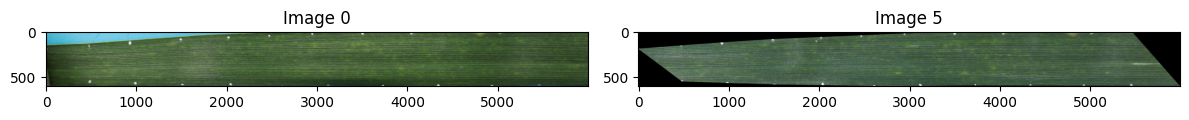

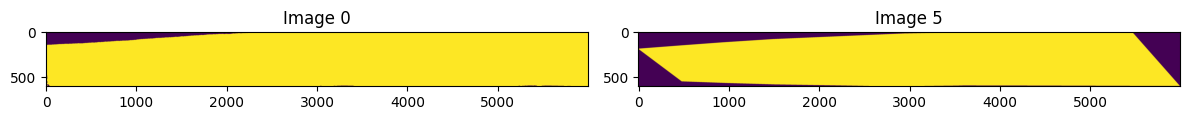

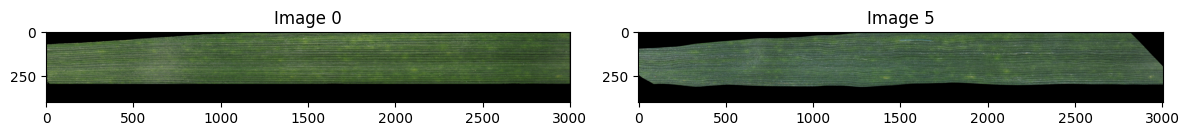

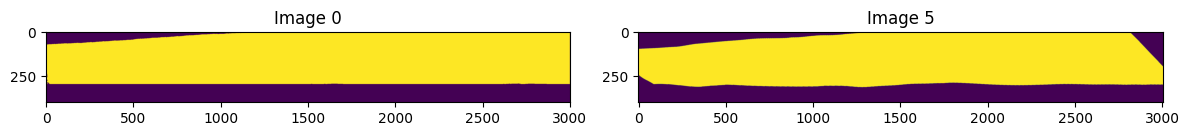

In [44]:
# piecewise bad, loftr good
moving_ind = 5

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070025_7", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

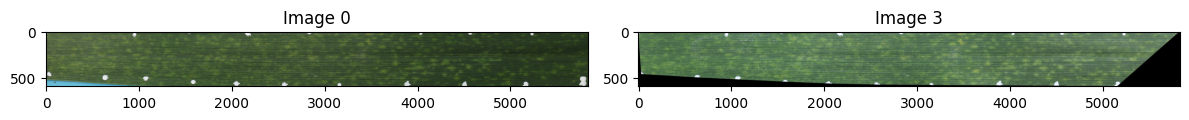

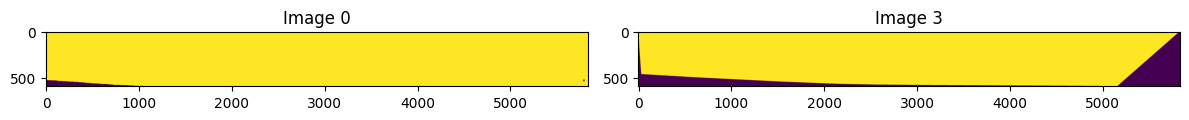

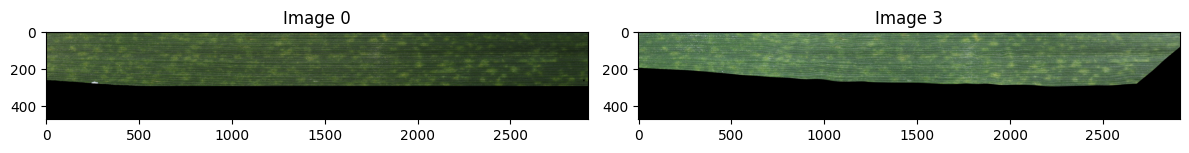

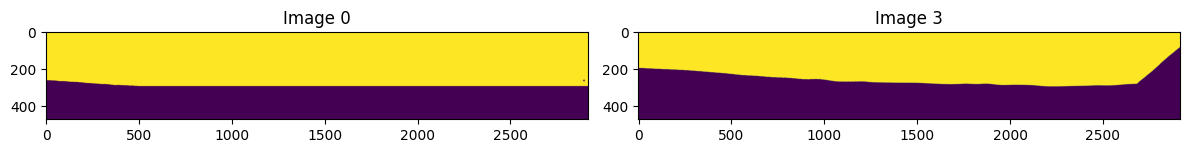

In [47]:
# piecewise bad, loftr not as bad?
moving_ind = 3

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070023_10", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

### With vs Without Markers

In [54]:
common_leaves = set(df_full[df_full['registration_method']=='LoFTR + TPS ROI']['leaf_uid']) & set(df_full[df_full['registration_method']=='LoFTR + TPS ROI with Markers']['leaf_uid'])
df_paired = df_full[df_full['leaf_uid'].isin(common_leaves)]
df_paired = df_paired[df_paired['registration_method'] != "Pairwise Affine"]
df_paired_melt = df_paired.melt(id_vars=['leaf_uid','registration_method', 'fixed_image','moving_image'], value_vars=['MSE', 'NCC', 'MI', 'SSIM', 'IoU', 'Hausdorff'],)
print(df_paired['leaf_uid'].nunique())
df_paired.head()

4


leaf_uid registration_method  fixed_image  moving_image       MSE  \
13  ESWW0070020_1     LoFTR + TPS ROI            0             1  0.004503   
14  ESWW0070020_1     LoFTR + TPS ROI            0             2  0.021916   
15  ESWW0070020_1     LoFTR + TPS ROI            0             3  0.007644   
16  ESWW0070020_1     LoFTR + TPS ROI            0             4  0.027876   
17  ESWW0070020_1     LoFTR + TPS ROI            0             5  0.028360   

         NCC        MI      SSIM       IoU  Hausdorff  
13  0.057931  1.007095  0.416417  0.943841  25.019993  
14  0.020453  1.001438  0.362952  0.872782  65.000000  
15  0.073524  1.001737  0.325642  0.937827  24.000000  
16  0.077442  1.004736  0.294951  0.976703  18.027756  
17  0.049429  1.001678  0.276062  0.925476  28.442924

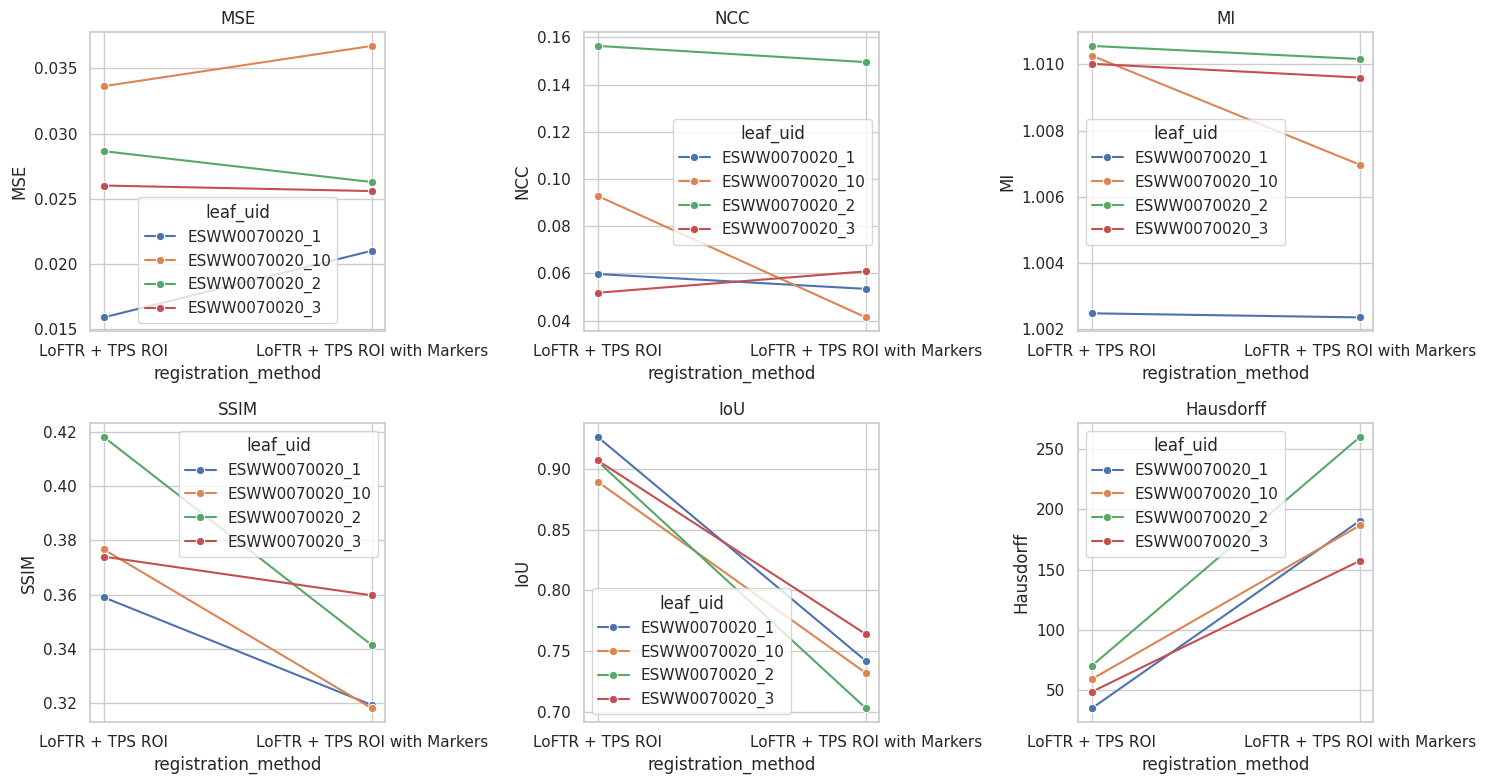

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax, errorbar=None)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

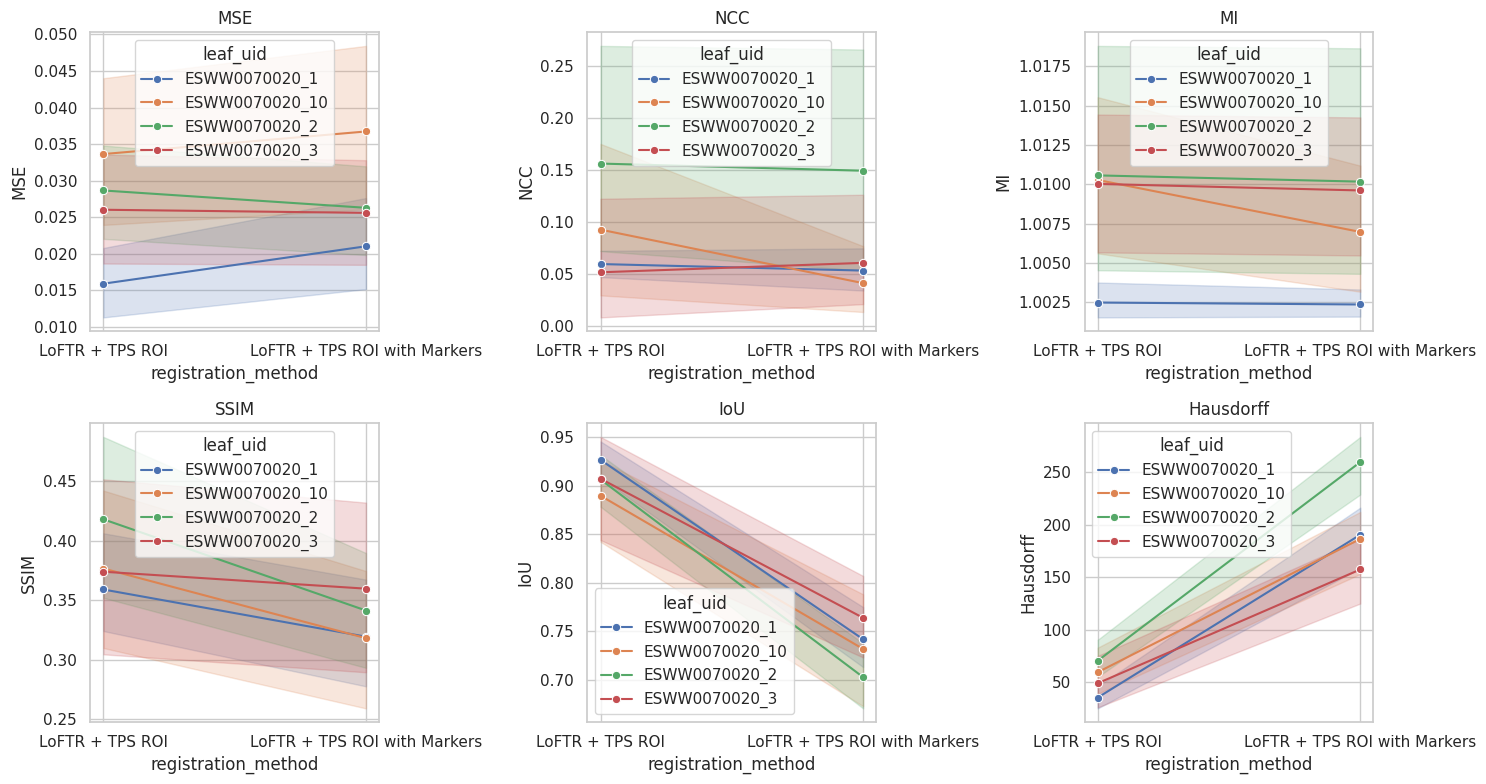

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

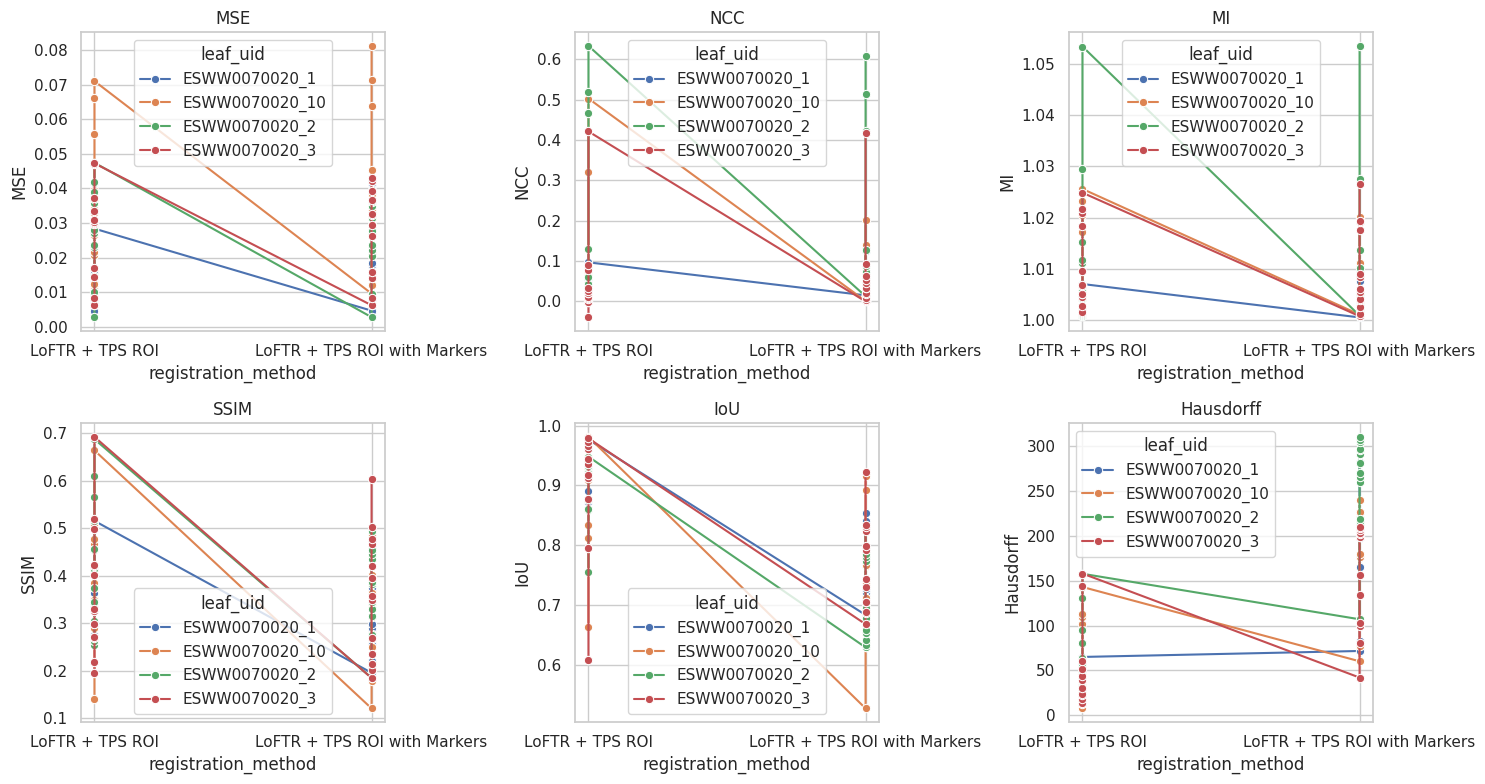

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax, estimator=None, errorbar=None)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

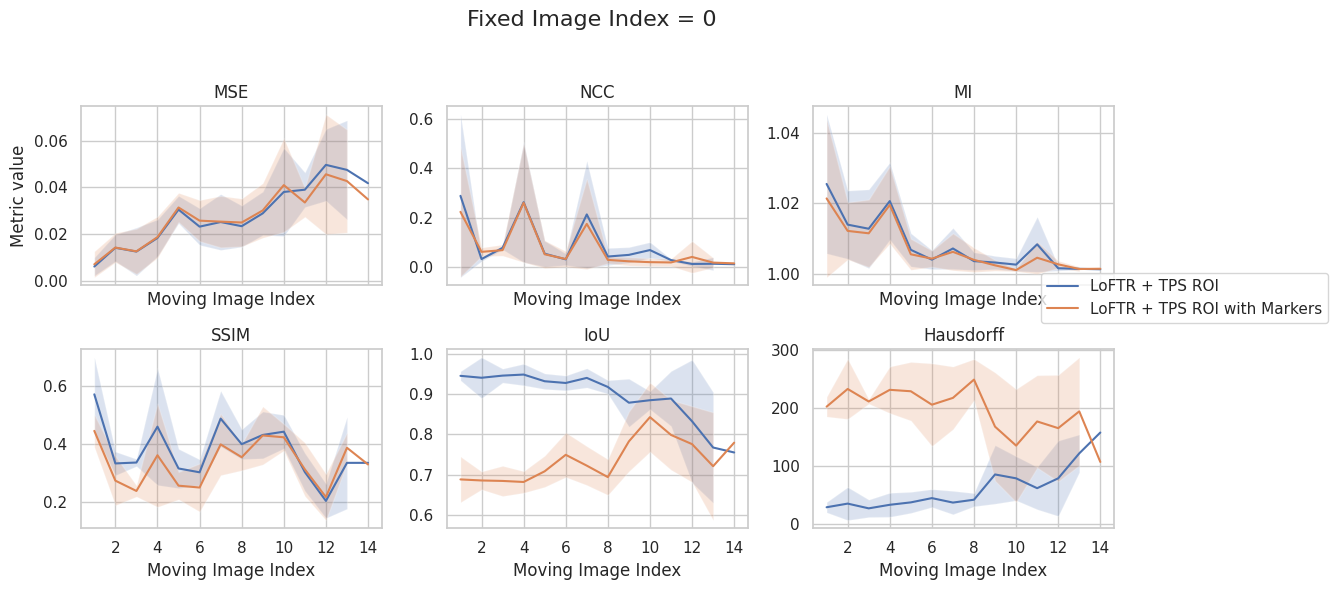

In [70]:
# average over leaf series for each index pair
df_agg = df_paired.groupby(['registration_method', 'fixed_image', 'moving_image'])[metrics].agg(["mean", "std"]).reset_index()
df_agg.columns = [ "_".join(col).rstrip("_") for col in df_agg.columns ]
df_agg.sample(5).sort_values(by=(['registration_method', 'fixed_image', 'moving_image']))

methods = ["LoFTR + TPS ROI", "LoFTR + TPS ROI with Markers"]
n_metrics = len(metrics)

n_rows = 2
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for method in methods:
        df_plot = df_agg[
            (df_agg["fixed_image"] == 0) &
            (df_agg["registration_method"] == method) &
            (df_agg["moving_image"] != 0)
        ].sort_values("moving_image")

        if df_plot.empty:
            continue

        x = df_plot["moving_image"]
        mean = df_plot[f"{metric}_mean"]
        std = df_plot[f"{metric}_std"]

        ax.plot(x, mean, label=method)
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, label="_nolegend_")

    ax.set_title(metric)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Moving Image Index")

# hide unused subplots
for ax in axes[len(metrics):]:
    ax.set_visible(False)

# shared y-label
axes[0].set_ylabel("Metric value")

# put legend far right outside
fig.legend(
    methods,
    loc="center right",
    bbox_to_anchor=(1.12, 0.5)
)

fig.suptitle("Fixed Image Index = 0", fontsize=16)

# tighten layout to remove empty space
fig.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


### Variance Analysis

In [23]:
rows = []

for keys, g in df_full.groupby(group_cols):
    n = g["leaf_uid"].nunique() # number of samples
    if n < 2:
        # not enough samples to compute sample variance
        continue

    tval = t.ppf(0.975, n - 1)

    # compute confidence interval half-width for each metric
    for metric in metrics:
        s = g[metric].std(ddof=1) # sample standard deviation
        half_width = tval * s / np.sqrt(n) # width of confidence interval
        m = g[metric].mean()
        
        rows.append({
            "registration_method": keys[0],
            "fixed_image": keys[1],
            "moving_image": keys[2],
            "metric": metric,
            "mean": m,
            "ci_half_width": half_width,            
        })

ci_param_df = pd.DataFrame(rows)
ci_param_df.head(5)


registration_method  fixed_image  moving_image metric      mean  \
0     LoFTR + TPS ROI            0             1    MSE  0.007963   
1     LoFTR + TPS ROI            0             1    NCC  0.185808   
2     LoFTR + TPS ROI            0             1     MI  1.020832   
3     LoFTR + TPS ROI            0             1   SSIM  0.487167   
4     LoFTR + TPS ROI            0             1    IoU  0.917000   

   ci_half_width  
0       0.001651  
1       0.097086  
2       0.007947  
3       0.054920  
4       0.030367

In [27]:
metric_tol = (
    ci_param_df
    .groupby(["registration_method", "metric"])#["ci_half_width"]
    #.max()
    .agg( overall_mean=("mean", "mean"), max_ci_half_width=("ci_half_width", "max"))
    .reset_index()
)
rel_tol = 0.05 # 5% relative tolerance
metric_tol["tolerance"] = rel_tol * metric_tol["overall_mean"].abs()
metric_tol["Confident"] = metric_tol["max_ci_half_width"] <= metric_tol["tolerance"]
metric_tol['n_target'] = np.ceil(n_uids * (metric_tol['max_ci_half_width'] / metric_tol['tolerance'])**2).astype(int)
metric_tol

registration_method metric  overall_mean  max_ci_half_width  tolerance  \
0         LoFTR + TPS     MI      1.017236           0.004566   0.050862   
1         LoFTR + TPS    MSE      0.043189           0.303678   0.002159   
2         LoFTR + TPS    NCC      0.099139           0.043457   0.004957   
3         LoFTR + TPS   SSIM      0.695947           0.072285   0.034797   
4     Pairwise Affine     MI      1.016601           0.067343   0.050830   
5     Pairwise Affine    MSE      0.038126           0.382457   0.001906   
6     Pairwise Affine    NCC      0.061739           0.141039   0.003087   
7     Pairwise Affine   SSIM      0.297321           0.146280   0.014866   

   Confident  n_target  
0       True         1  
1      False   1245915  
2      False      4843  
3      False       272  
4      False       111  
5      False   2535788  
6      False    131512  
7      False      6100

For each registration method and metric, the half-width of the Confidence Interval $CI$ indicates that the true mean of that metric lies within $\pm CI$ with probability $95\%$.  
The tolerance is relative to the mean over all metric values, with a relative tolerance of $5\%$.  
`n_target` is an estimate of how many samples would be needed to achieve the desired tolerance.  